In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display

openmeteo_csv = "kebithigollewa_openmeteo_solar_daily_2025_11.csv"
openmeteo_df = pd.read_csv(openmeteo_csv, parse_dates=["time"])

timeseries_csv = "timeseries_table_timeseries_table (4).csv"
radiation_df = pd.read_csv(timeseries_csv, sep=";")
radiation_df["time"] = pd.to_datetime(radiation_df["Timestamp"], format="%b %d %Y")
radiation_df = radiation_df.rename(columns={"Radiation": "radiation_observed"})[["time", "radiation_observed"]]

merged_df = openmeteo_df.merge(radiation_df, on="time", how="left")
merged_df.head()

,time,shortwave_radiation,direct_radiation,direct_normal_irradiance,diffuse_radiation,global_tilted_irradiance,radiation_observed
0,2025-11-01,6156.0,4564.0,6921.8,1592.0,6156.0,563.45
1,2025-11-02,6157.0,4931.0,7350.6,1226.0,6157.0,469.90
2,2025-11-03,6057.0,4752.0,7093.5,1305.0,6057.0,597.81
3,2025-11-04,5966.0,4578.0,6809.8,1388.0,5966.0,456.97
4,2025-11-05,5723.0,4057.0,5755.5,1666.0,5723.0,358.37


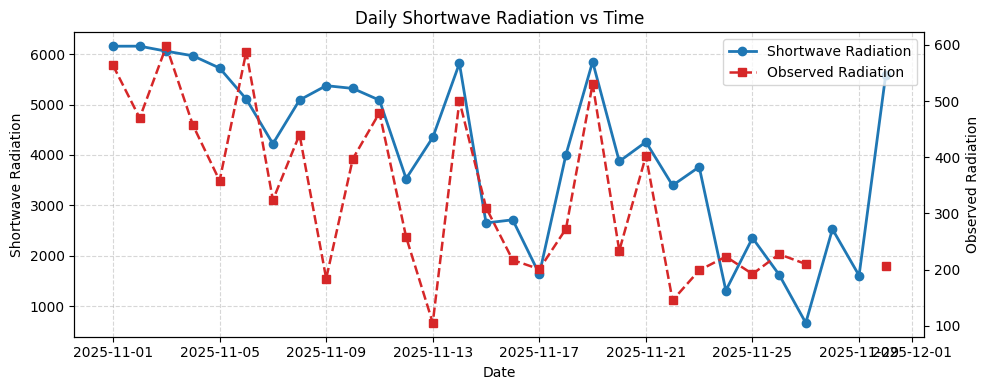

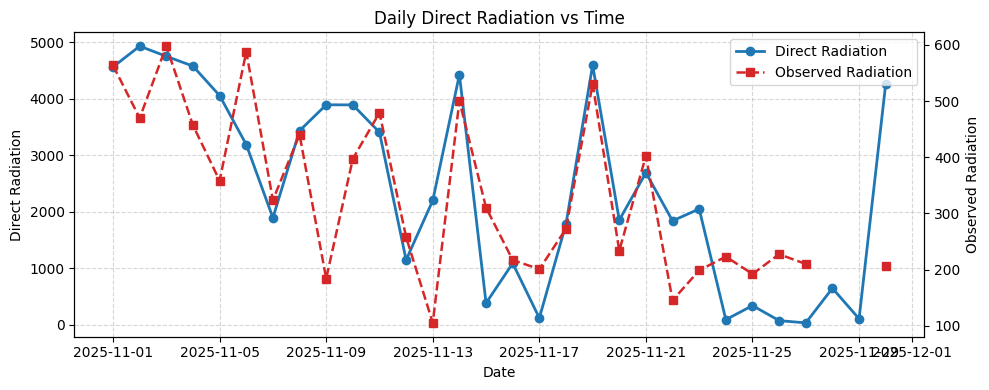

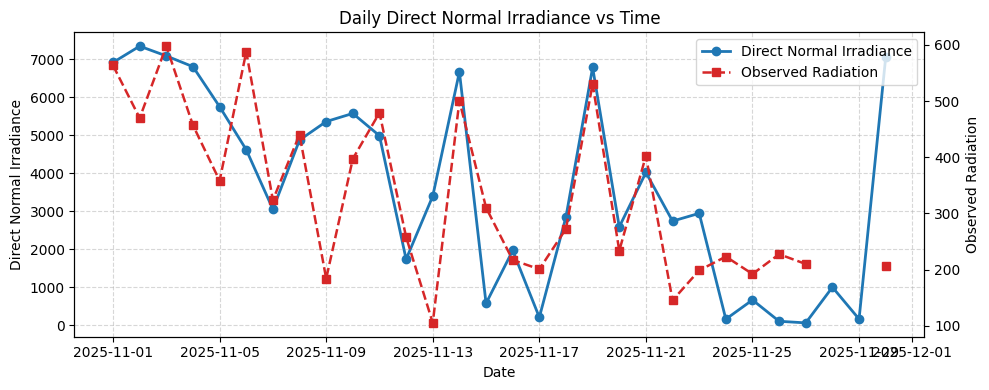

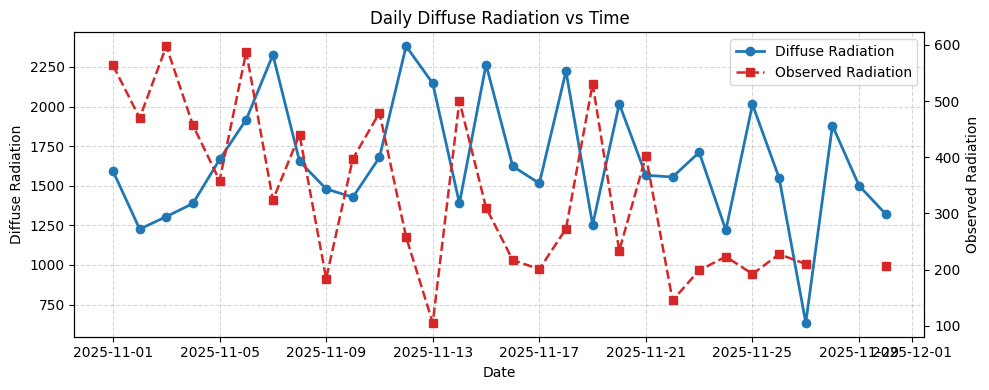

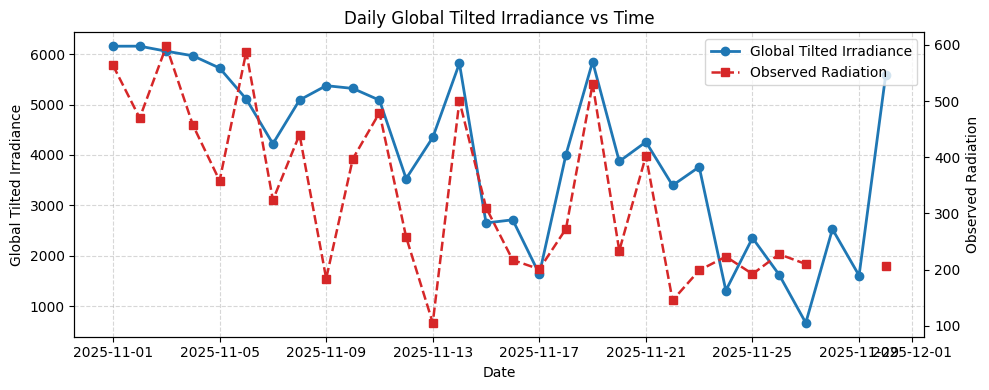

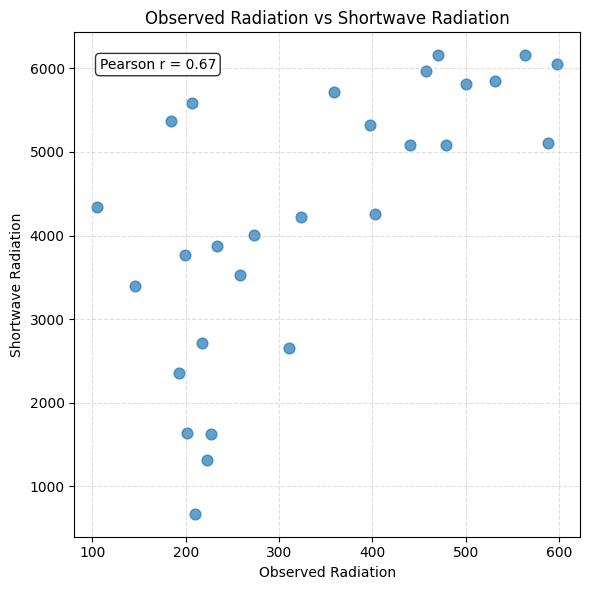

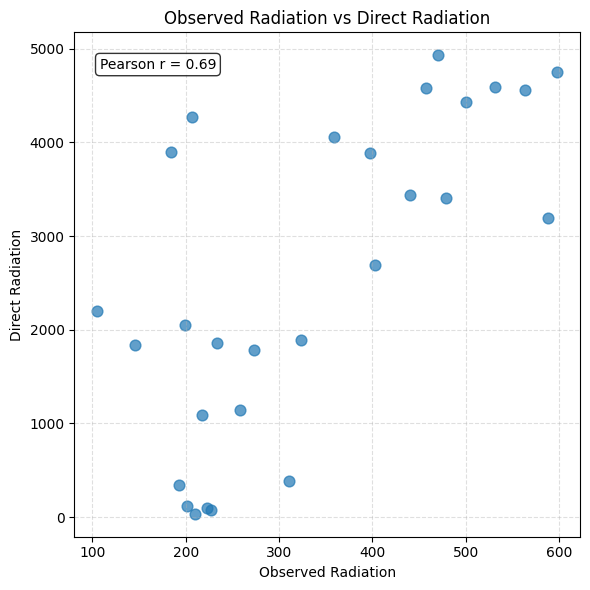

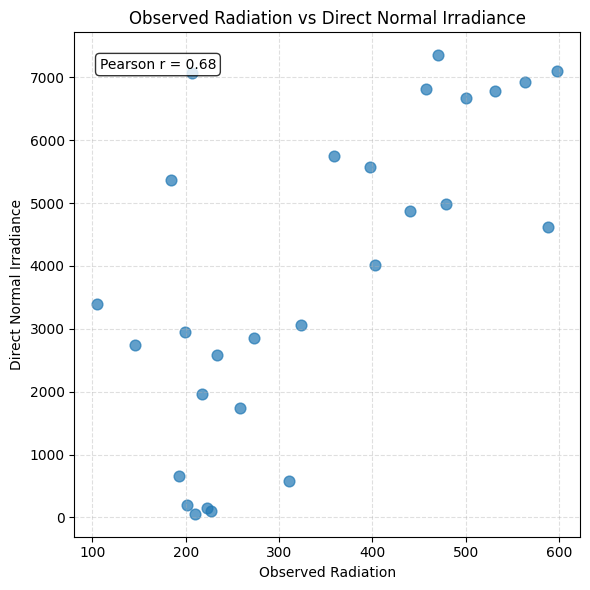

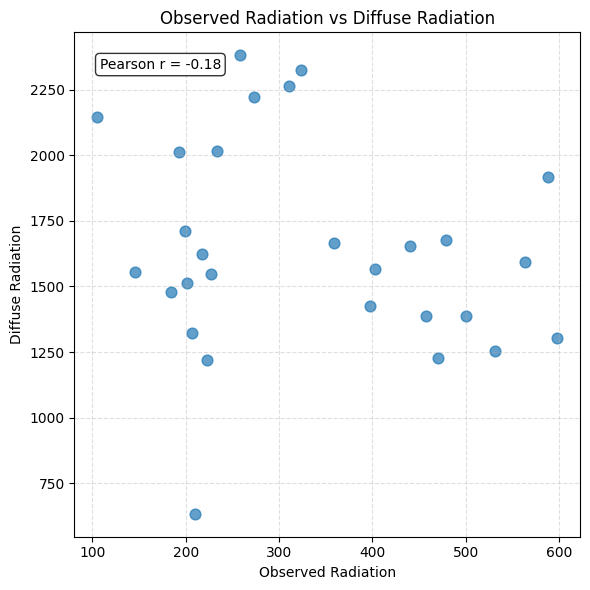

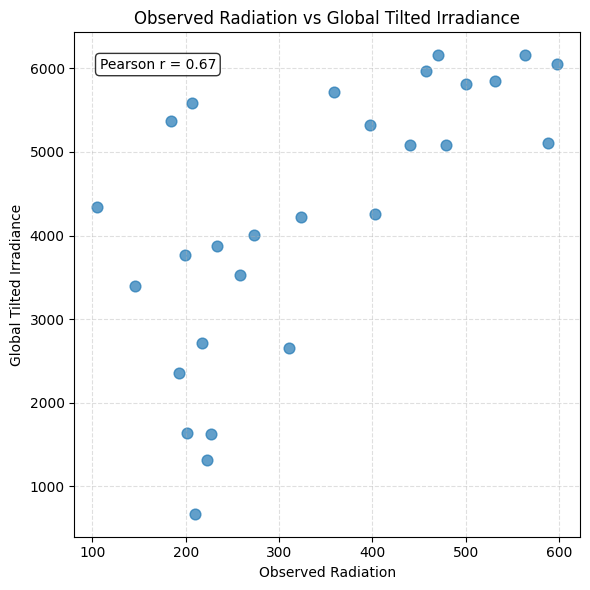

Saved plots to solar_radiation_analysis.pdf


In [6]:
metrics = [col for col in merged_df.columns if col not in ("time", "radiation_observed")]
pdf_path = "solar_radiation_analysis.pdf"

with PdfPages(pdf_path) as pdf:
    for metric in metrics:
        fig, ax_metric = plt.subplots(figsize=(10, 4))
        ax_metric.plot(merged_df["time"], merged_df[metric], marker="o", linewidth=2, label=metric.replace('_', ' ').title())
        ax_metric.set_title(f"Daily {metric.replace('_', ' ').title()} vs Time")
        ax_metric.set_xlabel("Date")
        ax_metric.set_ylabel(metric.replace('_', ' ').title())
        ax_metric.grid(True, linestyle="--", alpha=0.5)

        ax_rad = ax_metric.twinx()
        ax_rad.plot(merged_df["time"], merged_df["radiation_observed"], color="tab:red", linewidth=1.8, linestyle="--", marker="s", label="Observed Radiation")
        ax_rad.set_ylabel("Observed Radiation")

        lines, labels = ax_metric.get_legend_handles_labels()
        lines2, labels2 = ax_rad.get_legend_handles_labels()
        ax_metric.legend(lines + lines2, labels + labels2, loc="upper right")

        fig.tight_layout()
        pdf.savefig(fig)
        plt.show()

    for metric in metrics:
        scatter_data = merged_df[["radiation_observed", metric]].dropna()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(scatter_data["radiation_observed"], scatter_data[metric], s=60, alpha=0.7)
        ax.set_title(f"Observed Radiation vs {metric.replace('_', ' ').title()}")
        ax.set_xlabel("Observed Radiation")
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.grid(True, linestyle="--", alpha=0.4)

        if not scatter_data.empty:
            corr = scatter_data.corr().iloc[0, 1]
            ax.text(0.05, 0.95, f"Pearson r = {corr:.2f}", transform=ax.transAxes, ha="left", va="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
        else:
            ax.text(0.5, 0.5, "No overlapping data", transform=ax.transAxes, ha="center", va="center")

        fig.tight_layout()
        pdf.savefig(fig)
        plt.show()

print(f"Saved plots to {pdf_path}")

In [8]:
analysis_targets = ["direct_radiation", "direct_normal_irradiance"]
loss_summary = []
per_day_losses = {}

for metric in analysis_targets:
    subset = merged_df[["time", "radiation_observed", metric]].dropna()
    if subset.empty:
        continue
    diff = subset[metric] - subset["radiation_observed"]
    subset = subset.assign(
        error=diff,
        abs_error=np.abs(diff),
        squared_error=diff ** 2
    )
    nonzero_mask = subset["radiation_observed"] != 0
    mape = np.nan
    if nonzero_mask.any():
        mape = (subset.loc[nonzero_mask, "abs_error"] / subset.loc[nonzero_mask, "radiation_observed"]).mean() * 100
    mse = subset["squared_error"].mean()
    mae = subset["abs_error"].mean()
    rmse = np.sqrt(mse)
    loss_summary.append({
        "metric": metric,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape_percent": mape
    })
    per_day_losses[metric] = subset[["time", metric, "radiation_observed", "error", "abs_error", "squared_error"]]

summary_df = pd.DataFrame(loss_summary)
display(summary_df)

for metric, table in per_day_losses.items():
    print(f"\nPer-day loss details for {metric}:")
    display(table)

,metric,mae,mse,rmse,mape_percent
0,direct_radiation,2263.630357,7.412123e+06,2722.521482,711.364232
1,direct_normal_irradiance,3511.921786,1.775372e+07,4213.516505,1103.882655



Per-day loss details for direct_radiation:


,time,direct_radiation,radiation_observed,error,abs_error,squared_error
0,2025-11-01,4564.0,563.45,4000.55,4000.55,1.600440e+07
1,2025-11-02,4931.0,469.90,4461.10,4461.10,1.990141e+07
2,2025-11-03,4752.0,597.81,4154.19,4154.19,1.725729e+07
3,2025-11-04,4578.0,456.97,4121.03,4121.03,1.698289e+07
4,2025-11-05,4057.0,358.37,3698.63,3698.63,1.367986e+07
5,2025-11-06,3190.0,587.92,2602.08,2602.08,6.770820e+06
6,2025-11-07,1896.0,323.86,1572.14,1572.14,2.471624e+06
7,2025-11-08,3435.0,440.45,2994.55,2994.55,8.967330e+06
8,2025-11-09,3894.0,184.08,3709.92,3709.92,1.376351e+07
9,2025-11-10,3892.0,397.36,3494.64,3494.64,1.221251e+07



Per-day loss details for direct_normal_irradiance:


,time,direct_normal_irradiance,radiation_observed,error,abs_error,squared_error
0,2025-11-01,6921.8,563.45,6358.35,6358.35,4.042861e+07
1,2025-11-02,7350.6,469.90,6880.70,6880.70,4.734403e+07
2,2025-11-03,7093.5,597.81,6495.69,6495.69,4.219399e+07
3,2025-11-04,6809.8,456.97,6352.83,6352.83,4.035845e+07
4,2025-11-05,5755.5,358.37,5397.13,5397.13,2.912901e+07
5,2025-11-06,4620.9,587.92,4032.98,4032.98,1.626493e+07
6,2025-11-07,3053.1,323.86,2729.24,2729.24,7.448751e+06
7,2025-11-08,4876.9,440.45,4436.45,4436.45,1.968209e+07
8,2025-11-09,5363.7,184.08,5179.62,5179.62,2.682846e+07
9,2025-11-10,5577.8,397.36,5180.44,5180.44,2.683696e+07
